<a href="https://colab.research.google.com/github/bdwalker1/UCSD_MLE_Bootcamp_Capstone/blob/master/PreviousWorkReview/XGBoost_IoT_Malicious_Detection_Bruce_Walker_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **20.6.2 Capstone: Survey Existing Research and Reproduce Available Solutions**

*This notebook created by Rémi Blier was retrieved from Kaggle (https://www.kaggle.com/code/rem4000/xgboost-iot-malicious-detection-99-99-accuracy) and adopted to work in my Google CoLab account.*

I've added inline notes (look for comments starting with "NOTE:") for observations and/or if I have modified code for some reason.

My observations and conclusions are at the bottom of the Notebook.

---
---


### Citations
#### Dataset
“Stratosphere Laboratory. A labeled dataset with malicious and benign IoT network traffic. January 22th. Agustin Parmisano, Sebastian Garcia, Maria Jose Erquiaga. https://www.stratosphereips.org/datasets-iot23
#### Model advices
Christian Desrosiers, École de Technologie Supérieur (ETS), for proposing XGBoost model.
#### Notebook creation
Rémi Blier, École de Technologie Supérieur (ETS), for creating this notebook.
#### XGBoost model
Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785–794). New York, NY, USA: ACM. https://doi.org/10.1145/2939672.2939785

In [1]:
# NOTE: Connect to my Google drive for data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# NOTE: Install needed packages
!pip install keras-tuner
!pip install xgboost
!pip install scikit-learn==1.5.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 98.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [3]:
# NOTE: This cell is just to test if XGBoost is loaded/working

# from xgboost import XGBClassifier
# from sklearn.feature_selection import SelectFromModel
# from sklearn.datasets import make_classification

# # Create a dataset
# XX, yy = make_classification(n_samples=1000, n_features=10, random_state=42)

# # Fit the model
# model = XGBClassifier()
# model.fit(XX, yy)

# # Feature selection
# selection = SelectFromModel(model, threshold=0.5, prefit=True)
# XX_selected = selection.transform(XX)
# print("Selected features shape:", XX_selected.shape)

# Import Data

In [4]:
# NOTE: Setting the path to the data files on my Google drive

# Path for CoLab
data_path = "/content/drive/MyDrive/UCSD_MLE_Bootcamp_Capstone/data/MalwareDetectionInNetworkTrafficData/raw"

# Path for Windows PC
# data_path = "/My Drive/UCSD_MLE_Bootcamp_Capstone/data/MalwareDetectionInNetworkTrafficData"

In [5]:
def find_csv_delimiter(file_path, max_lines=5):
    with open(file_path, 'r', newline='') as file:
        sample_lines = [file.readline().strip() for _ in range(max_lines)]

    delimiters = [',', ';', '\t', '|']  # Common delimiters to check

    best_delimiter = ','
    max_delimiter_count = 0

    for delimiter in delimiters:
        delimiter_count = sum(line.count(delimiter) for line in sample_lines)
        if delimiter_count > max_delimiter_count:
            best_delimiter = delimiter
            max_delimiter_count = delimiter_count

    return best_delimiter

In [6]:
import csv
import numpy as np
from sklearn.preprocessing import LabelEncoder

def extract_data_from_csv(file_path, delimiter=','):
    data = []  # Create a list to store the data

    # Open the CSV file for reading
    with open(file_path, mode='r', newline='') as file:
        # Create a CSV reader object with the pipe delimiter

        csv_reader = csv.reader(file, delimiter=delimiter)

        # Read the header row
        header = next(csv_reader)

        # Iterate through the rows in the CSV file
        for row in csv_reader:
            data.append(row)

    return data

In [7]:
data = []

import os
cpt = 0

# NOTE: changing directory to my data path
# for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk(data_path):

        for filename in filenames:
# NOTE: Remi limited loading to first two files. I changed to load data from all files
#            if cpt < 2:
                file_path = os.path.join(dirname, filename)
                delimiter = find_csv_delimiter(file_path)
                data += extract_data_from_csv(file_path, delimiter)
                print(os.path.join(dirname, filename))
                cpt+=1
#            else:
#                break


# Convert your data to a NumPy array
data = np.array(data)

print(data.shape)

/content/drive/MyDrive/UCSD_MLE_Bootcamp_Capstone/data/MalwareDetectionInNetworkTrafficData/raw/CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv
/content/drive/MyDrive/UCSD_MLE_Bootcamp_Capstone/data/MalwareDetectionInNetworkTrafficData/raw/CTU-IoT-Malware-Capture-3-1conn.log.labeled.csv
/content/drive/MyDrive/UCSD_MLE_Bootcamp_Capstone/data/MalwareDetectionInNetworkTrafficData/raw/CTU-IoT-Malware-Capture-21-1conn.log.labeled.csv
/content/drive/MyDrive/UCSD_MLE_Bootcamp_Capstone/data/MalwareDetectionInNetworkTrafficData/raw/CTU-IoT-Malware-Capture-20-1conn.log.labeled.csv
/content/drive/MyDrive/UCSD_MLE_Bootcamp_Capstone/data/MalwareDetectionInNetworkTrafficData/raw/CTU-IoT-Malware-Capture-34-1conn.log.labeled.csv
/content/drive/MyDrive/UCSD_MLE_Bootcamp_Capstone/data/MalwareDetectionInNetworkTrafficData/raw/CTU-IoT-Malware-Capture-35-1conn.log.labeled.csv
/content/drive/MyDrive/UCSD_MLE_Bootcamp_Capstone/data/MalwareDetectionInNetworkTrafficData/raw/CTU-IoT-Malware-Capture-48-1conn.log

In [8]:
# NOTE: To stay within available resources and save time,
#       I am selecting a random 3 million records from the dataset

# Shuffle the data and take 3M to use in our training/validation/testing
np.random.shuffle(data)
data = data[0:3000000]

print(data.shape)

(3000000, 23)


In [9]:
# NOTE: Creating a copy at this point so I don't have to reload everytime
data_save = data.copy()

In [10]:
# NOTE: This code is for when I want to reset to this point
data = data_save.copy()

In [11]:
print(data[0])

['1551379416.609944' 'C9rXSc1MhYDt1VCcgb' '192.168.1.200' '40132'
 '177.69.166.102' '23' 'tcp' '-' '3.094976' '0' '0' 'S0' '-' '-' '0' 'S'
 '6' '360' '0' '0' '-' 'Malicious   PartOfAHorizontalPortScan' '']


# Process Data

In [12]:
# NOTE: Displaying column names so I know which is which
columns='ts|uid|id.orig_h|id.orig_p|id.resp_h|id.resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|tunnel_parents|label|detailed-label'.split('|')
for i in range(len(columns)):
    print(f'{i}: {columns[i]}')


0: ts
1: uid
2: id.orig_h
3: id.orig_p
4: id.resp_h
5: id.resp_p
6: proto
7: service
8: duration
9: orig_bytes
10: resp_bytes
11: conn_state
12: local_orig
13: local_resp
14: missed_bytes
15: history
16: orig_pkts
17: orig_ip_bytes
18: resp_pkts
19: resp_ip_bytes
20: tunnel_parents
21: label
22: detailed-label


In [13]:
columns_to_remove = [0, 1, 2, 4, 12, 13, 14, 20, 22]

# NOTE: List columns being dropped
print('Removing columns:')
new_columns = []
for i in range(len(columns)):
    if i in columns_to_remove:
      print(f'\t{columns[i]}')
    else:
      new_columns.append(columns[i])
columns = new_columns

# Remove columns using NumPy's array slicing
data = np.delete(data, columns_to_remove, axis=1)

Removing columns:
	ts
	uid
	id.orig_h
	id.resp_h
	local_orig
	local_resp
	missed_bytes
	tunnel_parents
	detailed-label


In [14]:
# NOTE: Look at what we have left
print(columns)

for i in range(5):
  print(data[i])

['id.orig_p', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'label']
['40132' '23' 'tcp' '-' '3.094976' '0' '0' 'S0' 'S' '6' '360' '0' '0'
 'Malicious   PartOfAHorizontalPortScan']
['13312' '80' 'tcp' '-' '-' '-' '-' 'RSTOS0' 'I' '1' '40' '0' '0'
 'Malicious   DDoS']
['52544' '23' 'tcp' '-' '3.127974' '0' '0' 'S0' 'S' '3' '180' '0' '0'
 'Benign']
['48896' '992' 'tcp' '-' '-' '-' '-' 'RSTOS0' 'I' '1' '40' '0' '0'
 'Malicious   DDoS']
['52204' '23' 'tcp' '-' '1e-06' '0' '0' 'S0' 'S' '2' '120' '0' '0'
 'Malicious   PartOfAHorizontalPortScan']


In [15]:
# Make Malicious = 1 and Benign = 0
for row in data:
    if row[-1] == 'Benign':
        row[-1] = 0
    else:
        row[-1] = 1

In [16]:
columns_to_transform = [3, 4, 5, 6, 8]
# Columns to put 0 if '-'
zeros = [4, 5, 6]
# Replace '-'
for row in data:
    for column in columns_to_transform:
        if row[column] == '-' and column in zeros:
            row[column] = 0
        elif row[column] == '-' and column not in zeros:
            row[column] = 'Unkown'

columns_to_convert_to_float = [4]
# Convert columns to float
for row in data:
    for column in columns_to_convert_to_float:
        row[column] = float(row[column])

columns_to_convert_to_int = [0, 1, 5, 6, 8, 9, 10, 11]

# Convert columns to int
for row in data:
    for column in columns_to_convert_to_int:
        try:
            # Attempt to convert the value to an integer
            row[column] = int(row[column])
        except (ValueError, TypeError):
            pass

# Remove rows where first column contains ip address
rows_to_remove = []
for index, row in enumerate(data):
    # If the first column is an IP address
    if row[0].count('.') == 3:
        rows_to_remove.append(index)

print(f'Removing {len(rows_to_remove)} of {len(data)} rows.')

# Delete the rows by index
for index in sorted(rows_to_remove, reverse=True):
    del data[index]

Removing 0 of 3000000 rows.


In [17]:
# NOTE: Look at what we have left
print(columns)

for i in range(10):
  print(data[i])

['id.orig_p', 'id.resp_p', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'label']
['40132' '23' 'tcp' 'Unkown' '3.094976' '0' '0' 'S0' 'S' '6' '360' '0' '0'
 '1']
['13312' '80' 'tcp' 'Unkown' '0.0' '0' '0' 'RSTOS0' 'I' '1' '40' '0' '0'
 '1']
['52544' '23' 'tcp' 'Unkown' '3.127974' '0' '0' 'S0' 'S' '3' '180' '0' '0'
 '0']
['48896' '992' 'tcp' 'Unkown' '0.0' '0' '0' 'RSTOS0' 'I' '1' '40' '0' '0'
 '1']
['52204' '23' 'tcp' 'Unkown' '1e-06' '0' '0' 'S0' 'S' '2' '120' '0' '0'
 '1']
['2801' '23' 'tcp' 'Unkown' '0.0' '0' '0' 'S0' 'S' '1' '40' '0' '0' '1']
['29347' '62336' 'tcp' 'Unkown' '0.0' '0' '0' 'OTH' 'C' '0' '0' '0' '0'
 '1']
['34436' '81' 'tcp' 'Unkown' '0.0' '0' '0' 'S0' 'S' '1' '40' '0' '0' '1']
['33768' '23' 'tcp' 'Unkown' '3.150207' '0' '0' 'S0' 'S' '3' '180' '0' '0'
 '0']
['22123' '992' 'tcp' 'Unkown' '0.0' '0' '0' 'RSTOS0' 'I' '1' '40' '0' '0'
 '1']


In [18]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# columns_to_onehot = [0, 1, 2, 3, 7, 8]
columns_to_onehot = [2, 3, 7, 8]

print('Before one-hot encoding features:')
print(data[0])
print(data[0].shape)

onehot_encoder = OneHotEncoder(sparse_output=True)

dataCopy = data.copy()

addedCols = 0
for column in columns_to_onehot:
    print(f'Encoding column {column}...')
    column_values = data[:, column]
    onehot_encoded = onehot_encoder.fit_transform(column_values.reshape(-1, 1)).toarray()
    dataCopy = np.delete(dataCopy, column + addedCols, axis=1)

    # Insert the new columns
    for i, encoded_column in enumerate(onehot_encoded.T):
        dataCopy = np.insert(dataCopy, column + i + addedCols, encoded_column, axis=1)
        print('.', end='')
    print(f'Done encoding column {column}.')

    addedCols += onehot_encoded.shape[1] - 1

print(f'Encoding done.')
data = dataCopy


print('After one-hot encoding features:')
print(data[0])
print(data[0].shape)



Before one-hot encoding features:
['40132' '23' 'tcp' 'Unkown' '3.094976' '0' '0' 'S0' 'S' '6' '360' '0' '0'
 '1']
(14,)
Encoding column 2...
...Done encoding column 2.
Encoding column 3...
.......Done encoding column 3.
Encoding column 7...
............Done encoding column 7.
Encoding column 8...
...................................................................................................................Done encoding column 8.
Encoding done.
After one-hot encoding features:
['40132' '23' '0.0' '1.0' '0.0' '1.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '3.094976' '0' '0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '1.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '1.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 

In [19]:
ohe_data = data.copy()

In [20]:
  # Check if any of the data contains strings
for row in data:
    for column in row:
        if isinstance(column, str):
            #Convert the value to a float, if possible
            try:
                column = float(column)
            except ValueError:
                pass

# Initialize an empty list to store preprocessed data
preprocessed_data = []

# Iterate through the rows in the data
for row in data:
    try:
        # Convert all columns to floats in this row
        float_row = [float(column) if column != '-' else 0.0 for column in row]
        preprocessed_data.append(float_row)
    except ValueError:
        print('Skipping row with non-convertible values:', row)

data = preprocessed_data

# Check if data contains strings
for row in data:
    for column in row:
        if isinstance(column, str):
            print('Error: String found in data: ', column)
            break

preprocessed_data = data

# Convert preprocessed_data to a normal Python list of lists
preprocessed_data = [list(row) for row in preprocessed_data]




In [21]:
# Print the first 10 rows preprocessed data
for row in preprocessed_data[:10]:
    print(row)


[40132.0, 23.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.094976, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 360.0, 0.0, 0.0, 1.0]
[13312.0, 80.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

# Separate data

In [22]:
import random
import numpy as np

# Separate data

# Define the split ratios for training, validation, and test datasets
train_ratio = 0.70  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

train_val_indices = int((train_ratio + val_ratio) * len(preprocessed_data))

train_val_data = preprocessed_data[:train_val_indices]
test_data = preprocessed_data[train_val_indices:]

# Shuffle the data randomly
random.shuffle(train_val_data)
random.shuffle(test_data)

# Calculate the split points
total_records = len(train_val_data)
train_split = int(train_ratio * total_records)
val_split = int(val_ratio * total_records)

# Split the data into training, validation
train_data = train_val_data[:train_split]
val_data = train_val_data[train_split:]

In [23]:
train_labels = []
val_labels = []
test_labels = []

# Separate the labels from features vectors
train_temp = []
for row in train_data:
    newRow = []
    newRow = row[:len(row)-1]
    train_temp.append(newRow)
    train_labels.append(row[-1])

val_temp = []
for row in val_data:
    newRow = []
    newRow = row[:len(row)-1]
    val_temp.append(newRow)
    val_labels.append(row[-1])

test_temp = []
for row in test_data:
    newRow = []
    newRow = row[:len(row)-1]
    test_temp.append(newRow)
    test_labels.append(row[-1])

train_data = train_temp
val_data = val_temp
test_data = test_temp

In [24]:
# Convert your data to NumPy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)

val_data = np.array(val_data)
val_labels = np.array(val_labels)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Print rows and columns of the data
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)


(1785000, 146)
(1785000,)
(765000, 146)
(765000,)


# Train model

In [25]:
import tensorflow as tf
from tensorflow import keras
from keras_tuner.tuners import BayesianOptimization

# Check if train data contains strings
for row in train_data:
    for column in row:
        if isinstance(column, str):
            print('Error: String found in data: ', column)
            break

# Check if val data contains strings
for row in val_data:
    for column in row:
        if isinstance(column, str):
            print('Error: String found in data: ', column)
            break

In [26]:
import gc
gc.collect()

57

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define your XGBoost classifier and hyperparameter search space
xgb_model = XGBClassifier()
param_space = {
    'n_estimators': [100],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_space,
    n_iter=5,  # Adjust the number of iterations as needed
    scoring='accuracy',  # Use the appropriate scoring metric
    n_jobs=-1,  # Use all available CPU cores for parallel processing
    cv=5,  # Number of cross-validation folds
    random_state=42,  # Set a random seed for reproducibility
    verbose=3
)

# Perform hyperparameter optimization
random_search.fit(train_data, train_labels)

# Get the best hyperparameters and the best model
best_xgb_hps = random_search.best_params_
best_xgb_model = random_search.best_estimator_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [28]:
print(best_xgb_hps)

{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.9}


# Evaluate model on val set

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
# Evaluate the Random Forest model on the validation data
sgboost_val_predictions = random_search.predict(val_data)
sgboost_val_accuracy = np.mean(sgboost_val_predictions == val_labels)
print("Validation Accuracy (Random Forest):", sgboost_val_accuracy)

# Calculate and print classification report and confusion matrix for Random Forest
sgboost_val_report = classification_report(val_labels, sgboost_val_predictions)
sgboost_val_confusion = confusion_matrix(val_labels, sgboost_val_predictions)
print("Validation Classification Report (XGBoost):")
print(sgboost_val_report)
print("Validation Confusion Matrix (XGBoost):")
print(sgboost_val_confusion)


Validation Accuracy (Random Forest): 0.9923294117647059
Validation Classification Report (XGBoost):
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    268694
         1.0       1.00      0.99      0.99    496306

    accuracy                           0.99    765000
   macro avg       0.99      0.99      0.99    765000
weighted avg       0.99      0.99      0.99    765000

Validation Confusion Matrix (XGBoost):
[[268294    400]
 [  5468 490838]]


# Evaluate model on test set

In [30]:
# Evaluate the Random Forest model on the test data
sgboost_test_predictions = random_search.predict(test_data)
sgboost_test_accuracy = np.mean(sgboost_test_predictions == test_labels)
print("Test Accuracy (SGBoost):", sgboost_test_accuracy)

# Calculate and print classification report and confusion matrix for Random Forest
sgboost_test_report = classification_report(test_labels, sgboost_test_predictions)
sgboost_test_confusion = confusion_matrix(test_labels, sgboost_test_predictions)
print("Test Classification Report (XGBoost):")
print(sgboost_test_report)
print("Test Confusion Matrix (XGBoost):")
print(sgboost_test_confusion)

Test Accuracy (SGBoost): 0.9923688888888889
Test Classification Report (XGBoost):
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    158231
         1.0       1.00      0.99      0.99    291769

    accuracy                           0.99    450000
   macro avg       0.99      0.99      0.99    450000
weighted avg       0.99      0.99      0.99    450000

Test Confusion Matrix (XGBoost):
[[157994    237]
 [  3197 288572]]


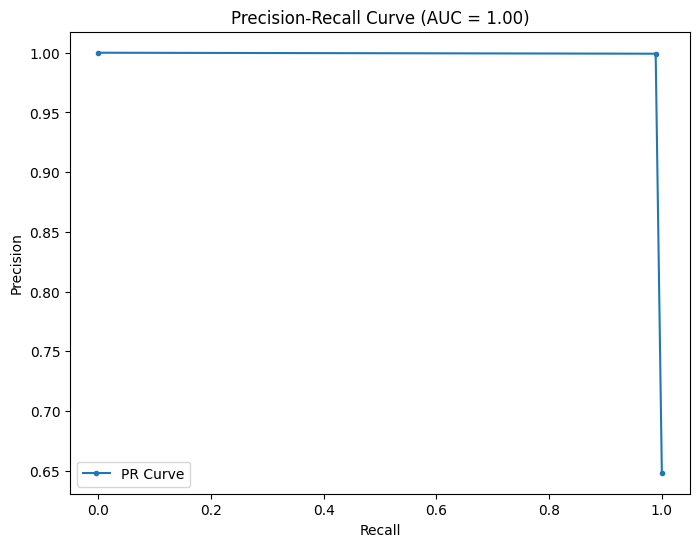

In [31]:
# NOTE: Checking precision and recall of the model
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(test_labels, sgboost_test_predictions)

# Calculate the area under the PR curve
auc_score = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.legend()
plt.show()

---
---
# **Observations:**

*   Rémi Blier's use of NumPy arrays as opposed to Pandas Dataframes makes inspecting the data at interim steps harder to understand as there are no column labels. In particular, the steps for dropping and encoding items required careful review to understand what they were doing.
*   Adding some additional print statements made it easier to follow what was happening, but more could still be done to make the code easier to understand.



# **Conclusions:**

*   The XGBoost algorithm seems to do a very good job of predicting target labels for the chosen dataset.
*   Though Blier's notbook had only been using the first two data files, the model worked just as well when loading all data and choosing a random 3 million records for the dataset.


